In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import tqdm

In [2]:
## ONLY LOAD EVERY 10TH ROW JUST FOR DEBUGGING

# Load data
df = pd.read_csv("filtered_data.csv")#, skiprows=lambda i: i % 10 != 0)

print(df.shape)
df

(18322712, 6)


,station_id,year,month,element,day,value
0,AGM00060490,1957,1,TMAX,1,178
1,AGM00060490,1957,1,TMAX,2,150
2,AGM00060490,1957,1,TMAX,3,161
3,AGM00060490,1957,1,TMAX,4,172
4,AGM00060490,1957,1,TMAX,5,172
...,...,...,...,...,...,...
18322707,ZA000067753,1990,11,PRCP,26,0
18322708,ZA000067753,1990,11,PRCP,27,0
18322709,ZA000067753,1990,11,PRCP,28,0
18322710,ZA000067753,1990,11,PRCP,29,0


In [3]:
# For each station and for each day, compute the midpoint temperature by
# averaging the min and max temperatures
daily_temp = df.where(np.logical_or(df["element"] == "TMIN", df["element"] == "TMAX"))
daily_temp = daily_temp.groupby(by=["station_id", "year", "month", "day"])
daily_temp = daily_temp.mean().reset_index()

daily_temp["value"] /= 10
daily_temp.rename(columns={"value": "TEMP"}, inplace=True)
daily_temp[["year", "month", "day"]] = daily_temp[["year", "month", "day"]].astype(int)
daily_temp.set_index(keys=["station_id", "year", "month", "day"], inplace=True)

print(daily_temp.shape)
daily_temp.head()

(3754308, 1)


TEMP
station_id  year month day      
AGM00060490 1957 1     1    17.8
                       2    15.0
                       3    16.1
                       4     9.7
                       5     9.7

In [4]:
daily_prcp = df[df["element"] == "PRCP"]
daily_prcp.drop(columns=["element"], inplace=True)
daily_prcp.rename(columns={"value": "PRCP"}, inplace=True)
daily_prcp.set_index(keys=["station_id", "year", "month", "day"], inplace=True)
print(daily_prcp.shape)
daily_prcp.head()

/tmp/ipykernel_16210/2042504302.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_prcp.drop(columns=["element"], inplace=True)
/tmp/ipykernel_16210/2042504302.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_prcp.rename(columns={"value": "PRCP"}, inplace=True)


(8436369, 1)


PRCP
station_id  year month day      
AGM00060490 1974 3     19     30
                       20      0
                       26     10
                       27      0
            1976 10    31   2570

In [5]:
daily_snow = df[df["element"] == "SNOW"]
daily_snow.drop(columns=["element"], inplace=True)
daily_snow.rename(columns={"value": "SNOW"}, inplace=True)
daily_snow.set_index(keys=["station_id", "year", "month", "day"], inplace=True)

print(daily_snow.shape)
daily_snow.head()

/tmp/ipykernel_16210/407896027.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_snow.drop(columns=["element"], inplace=True)
/tmp/ipykernel_16210/407896027.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_snow.rename(columns={"value": "SNOW"}, inplace=True)


(2563537, 1)


SNOW
station_id  year month day      
BF1FP000002 2016 3     24      0
                 4     4       0
                       5       0
                       11      0
                       12      0

In [6]:
# Inner-join all metrics together into one dataset, to eliminate missing values
metrics = daily_temp.join(daily_prcp, how="inner").join(daily_snow, how="inner")
print(metrics.shape)
metrics.head(10)

(1517441, 3)


TEMP  PRCP  SNOW
station_id  year month day                  
CA001012046 1941 6     15   20.0     0     0
                       16   13.6    36     0
                       17   13.1    74     0
                       18   11.9    48     0
                       19   12.5    46     0
                       20   13.3    33     0
                       21   13.6    23     0
                       22   15.0     0     0
                       23   15.3     0     0
                       24   15.0     3     0

In [7]:
"""
For each year and for each station:
1. Get 365 days of observations for temperature, precipitation, and snowfall (a.k.a. a 3 x 365 array)
2. Compute the correlation between the 365 temperatures and 365 precipitations, and the correlation between
the 365 temperatures and 365 snowfalls.

This will give us 2 2-D arrays, where one array has the temperature-precipitation correlation values
for every (year, station) pair, and the other array has the temperature-snowfall correlation values.
Both arrays have shape (# of stations, # of years).
"""
stations = sorted(metrics.index.get_level_values("station_id").unique().to_list())
years = sorted(metrics.index.get_level_values("year").unique().to_list())
station_year_pairs = list(itertools.product(stations, years))

# Compute correlations for a specific station and year
def compute_daily_correlations(station, year):
    # Get all observations of temperature, precipitation, and snowfall
    try:
        data = metrics.loc[(station, year)]

        # Compute correlation between temperature and precipitation
        corr1 = np.corrcoef(data["TEMP"], data["PRCP"])[0, 1]

        # Compute correlation between temperature and snowfall
        corr2 = np.corrcoef(data["TEMP"], data["SNOW"])[0, 1]

        return np.array([corr1, corr2])
    except KeyError:
        # This means that there isn't any data for this station and year
        # for us to compute correlations on, so return NaN values
        return np.array([np.nan, np.nan])

In [8]:
# Encode stations and years into integer indices so that we can look up values in the correlations array
# Use this to create an inverse mapping from station/year to station index/year index, respectively
indices, _ = pd.factorize(stations, sort=True)
station_index = {stations[i]: indices[i] for i in range(len(stations))}

indices, _ = pd.factorize(years, sort=True)
year_index = {years[i]: indices[i] for i in range(len(years))}

del indices

In [9]:
correlations = np.empty(shape=(len(stations), len(years), 2))
print(correlations.shape)
for (station, year) in tqdm.tqdm(station_year_pairs):
    correlations[station_index[station], year_index[year], :] = compute_daily_correlations(station, year)

(180, 145, 2)


  0%|          | 54/26100 [00:00<03:44, 115.86it/s]/home/adeet/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/adeet/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
  7%|▋         | 1861/26100 [00:12<02:10, 185.57it/s]/home/adeet/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/adeet/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/adeet/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
100%|██████████| 26100/26100 [02:36<00:00, 166.60it/s]


In [10]:
# pandas series mapping station ID's to names
station_names = pd.read_fwf("ghcnd-stations.txt", header=None, usecols=[0, 4])
station_names.rename(columns={0: "station_id", 4: "station_name"}, inplace=True)
station_names = station_names.set_index(keys="station_id").squeeze()
station_names.head()

station_id
ACW00011604    ST JOHNS COOLIDGE FLD
ACW00011647                 ST JOHNS
AE000041196      SHARJAH INTER. AIRP
AEM00041194               DUBAI INTL
AEM00041217           ABU DHABI INTL
Name: station_name, dtype: object

In [11]:
# Plot a heatmap of correlations between temperature and precipitation, for each station and each year
def plot_heatmap(col_name):
    if col_name == "PRCP":
        col = 0
    elif col_name == "SNOW":
        col = 1
    else:
        raise ValueError("Invalid column name")
    
    year_tick_frequency = 11
    station_tick_frequency = 8

    plt.figure(figsize=(10, 10))
    plt.imshow(correlations[:, :, col], cmap="seismic")
    plt.colorbar()
    plt.xticks(ticks=np.arange(len(years))[::year_tick_frequency], labels=years[::year_tick_frequency])
    plt.yticks(ticks=np.arange(len(stations))[::station_tick_frequency], labels=station_names[stations[::station_tick_frequency]])
    plt.xlim(0, len(years))
    plt.ylim(0, len(stations))
    plt.grid()
    plt.show()

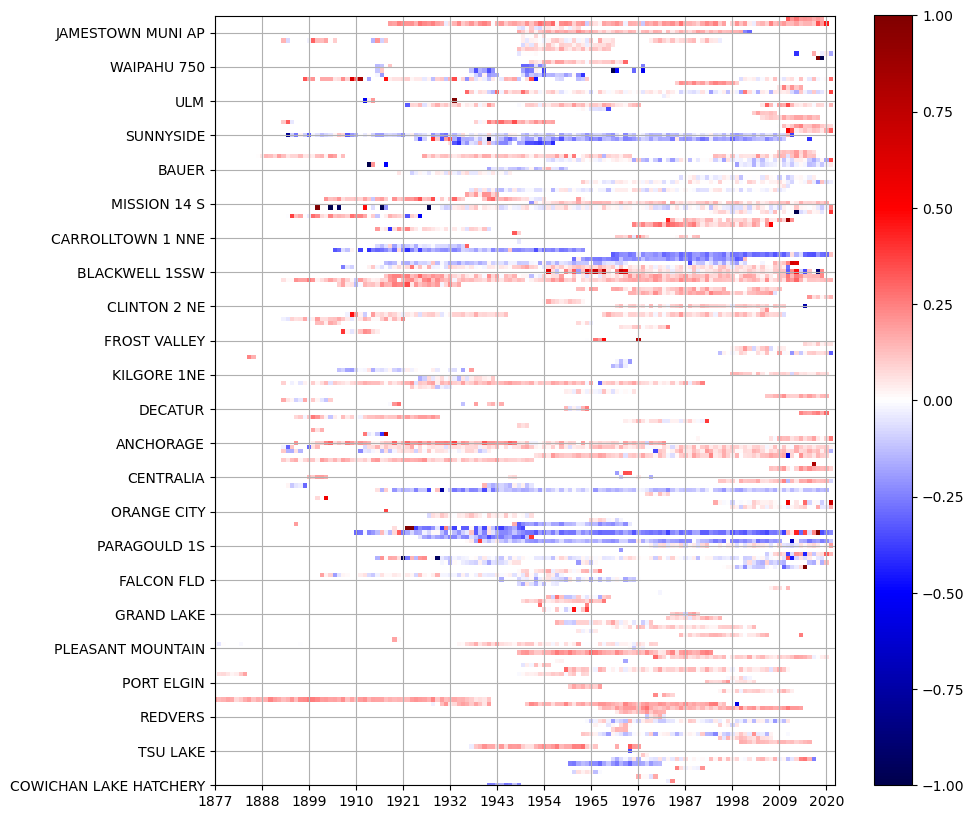

In [12]:
plot_heatmap("PRCP")

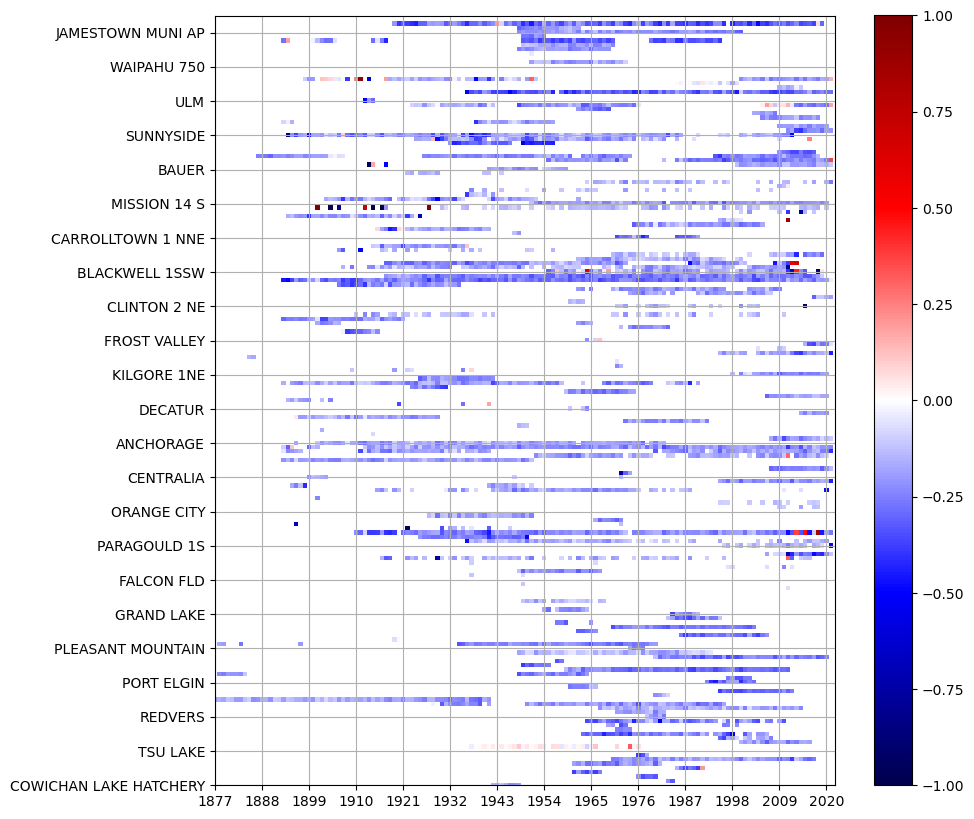

In [13]:
plot_heatmap("SNOW")